In [28]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
import sklearn.metrics as metrics
from time import time

## Datenbank einbinden
* Temperatursensor 1

In [29]:
connection = sql.connect("gcs_gh_10012022.db")

query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

In [30]:
df_temp1 = df_temp1.sort_index().loc['2021-02-17':'2021-02-28']

## Ausreißer behandeln
https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
https://github.com/kdrelczuk/medium/blob/master/anomalies_local.py#L37

In [31]:
column = df_temp1['value']

k = int(len(column) * (0.15/100))
N = len(column)
print("Window size: ", k)
print("Datapoints: ", N)

time = np.arange(0,N)
column = column.to_numpy()

get_bands = lambda df_temp1 : (np.mean(df_temp1) + 3*np.std(df_temp1), np.mean(df_temp1) - 3*np.std(df_temp1))

Window size:  4
Datapoints:  3274


In [32]:
bands = [get_bands(column[range(0 if i - k < 0 else i-k ,i + k if i + k < N else N)]) for i in range(0,N)]
upper, lower = zip(*bands)

In [33]:
anomalies = (df_temp1['value'] > upper) | (df_temp1['value'] < lower)

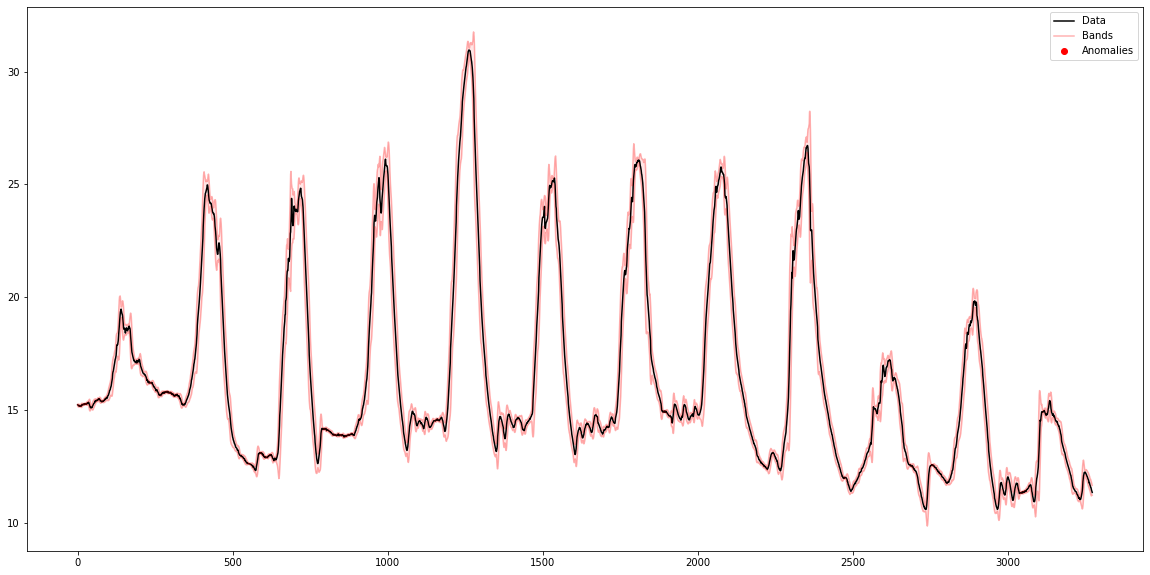

In [34]:
plt.figure(figsize=(20,10))
plt.plot(time,column,'k',label='Data')
plt.plot(time,upper,'r-',label='Bands',alpha=0.3)
plt.plot(time,lower,'r-',alpha=0.3)

plt.plot(time[anomalies],column[anomalies],'ro',label='Anomalies')
plt.fill_between(time, upper, lower,facecolor='red',alpha=0.1)
plt.legend()

## Datenlücken, duplizierte Indices behandeln

In [35]:
# prüfen ob doppelte Index-Werte (Timestamp) vorhanden 
print('TS has duplicates:', df_temp1.index.has_duplicates)
print('TS has NaN:', df_temp1['value'].isna().any())

# dopplte Index-Werte der Ausgangszeitreihe anzeigen 
df_temp1_duplicates = df_temp1[df_temp1.index.duplicated()]
print(df_temp1_duplicates)
print()

# Zeitreihe nach Behandlung der Indizes und Lücken durch Zusammenfassen anzeigen
df_temp1_5min = df_temp1.resample('5Min').mean()
print('TS 5min Intervals has duplicates:', df_temp1_5min.index.has_duplicates)
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

## Zeiträume sehen, in denen keine Daten vorhanden sind und durch das Zusammenfassen zu NaN werden
# print(df_temp1_5min.head(60))
# print(df_temp1.head(60))

TS has duplicates: True
TS has NaN: False
                        value
timestamp                    
2021-02-17 17:11:56  17.17060
2021-02-17 17:11:56  17.17060
2021-02-17 17:11:56  17.10117
2021-02-25 16:35:40  22.95186
2021-02-25 16:35:40  22.97856
2021-02-25 16:35:41  22.97856

TS 5min Intervals has duplicates: False
TS 5min Intervals has NaN: True


In [36]:
df_temp1_5min = df_temp1_5min.fillna(method='ffill')
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

TS 5min Intervals has NaN: False


## Daten zusammenfassen

In [37]:
df_temp1_hourly = df_temp1_5min.resample('H').mean()

## Stationarität

### Prüfen der Stationarität

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

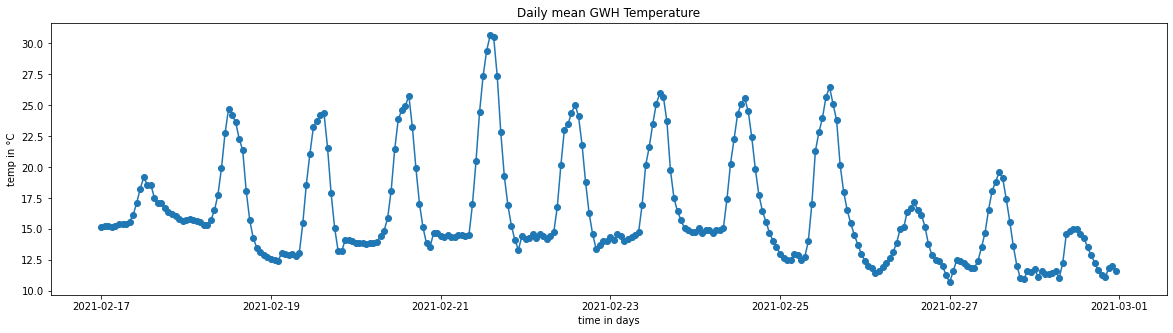

In [38]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

In [39]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.6504779547344282
p-value: 0.4567911690852536
Critial Values:
   1%, -3.4547128138328875
Critial Values:
   5%, -2.8722649771800155
Critial Values:
   10%, -2.5724850011573914


Da (p-Wert) 0.0003 < (p-Wert Schwelle) 0.05 , wird die Nullhyppthese abgelehnt. Die Zeitreihe ist stationär. <br>

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

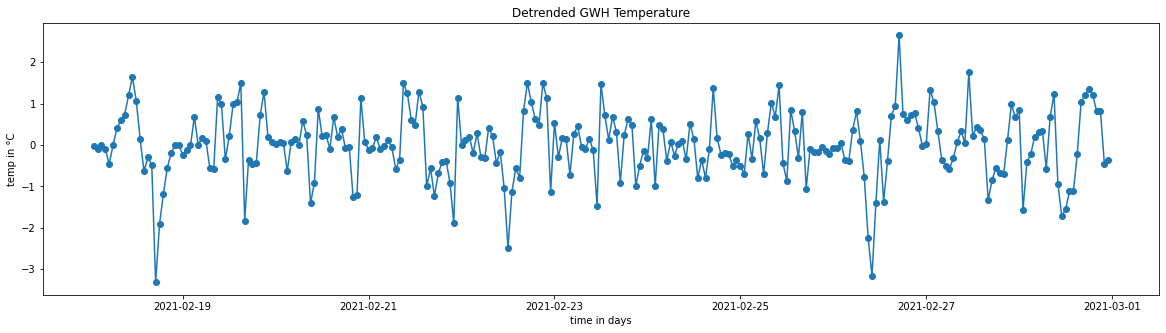

In [40]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff - series_temp1_stationary_diff.shift(1)
df_temp1_stationary = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_stationary.columns.values[0] = "value"

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.scatter(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [41]:
df_temp1_stationary = df_temp1_stationary.fillna(method='ffill').dropna()

series = df_temp1_stationary
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.3169926802815235
p-value: 3.1328398920912434e-08
Critial Values:
   1%, -3.456780859712
Critial Values:
   5%, -2.8731715065600003
Critial Values:
   10%, -2.572968544


## Autocorrelation

### ACF

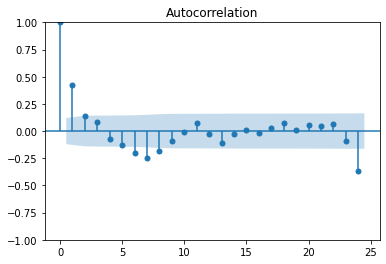

In [42]:
acf_result = stattools.acf(df_temp1_stationary)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_temp1_stationary, lags=24)

### PACF

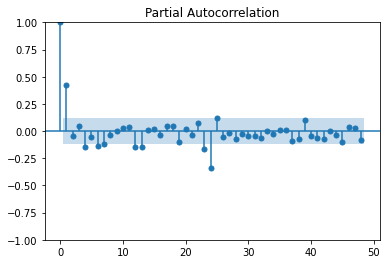

In [43]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_temp1_stationary,  method='ywm', lags=48)

## Daten splitten

In [44]:
# Frequenz der Zeitreihe wird festgelegt
df_temp1_modelling_data = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))

In [45]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_data = df_temp1_modelling_data.sort_index().loc['2021-02-17':'2021-02-25']
test_data = df_temp1_modelling_data.sort_index().loc['2021-02-26':'2021-02-28']

In [46]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

## SARIMA

## auto_arima

In [47]:
stepwise_fit = auto_arima(train_data,
                            test='adf',
                            m=24,
                            seasonal=True,
                            trace = True,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=421.825, Time=2.80 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=1244.554, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=854.471, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=1861.069, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=477.381, Time=0.92 sec
 ARIMA(2,0,2)(1,0,0)[24] intercept   : AIC=440.874, Time=2.37 sec
 ARIMA(2,0,2)(2,0,1)[24] intercept   : AIC=422.370, Time=10.70 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=422.012, Time=10.27 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=509.336, Time=0.26 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=453.545, Time=4.39 sec
 ARIMA(2,0,2)(2,0,0)[24] intercept   : AIC=421.552, Time=7.33 sec
 ARIMA(1,0,2)(2,0,0)[24] intercept   : AIC=441.285, Time=4.71 sec
 ARIMA(2,0,1)(2,0,0)[24] intercept   : AIC=421.168, Time=6.69 sec
 ARIMA(2,0,1)(1,0,0)[24] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  216
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 24)   Log Likelihood                -203.584
Date:                             Sun, 03 Jul 2022   AIC                            421.168
Time:                                     21:46:16   BIC                            444.795
Sample:                                          0   HQIC                           430.713
                                             - 216                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3851      0.127      3.032      0.002       0.136       0.634
ar.L1          1.6628      0.065     25.464      0.000       1.535       1.791
ar.L2         -0.7586      0.063    -12.109      0.000      -0.881      -0.636
ma.L1         -0.3035      0.097     -3.133      0.002      -0.493      -0.114
ar.S.L24       0.4250      0.055      7.738      0.000       0.317       0.533
ar.S.L48       0.3410      0.053      6.422      0.000       0.237       0.445
sigma2         0.3486      0.027     12.757      0.000       0.295       0.402
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                29.92
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.11
Prob(H) (two-sided):                  0.26   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### SARIMA(2,0,1)x(2,0,0)24

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Mean absolute error (MAE):  1.458367456969868
Mean squared error (MSE):  3.6646219487824205
Root Mean sqaured error (RMSE):  1.9143202315136358


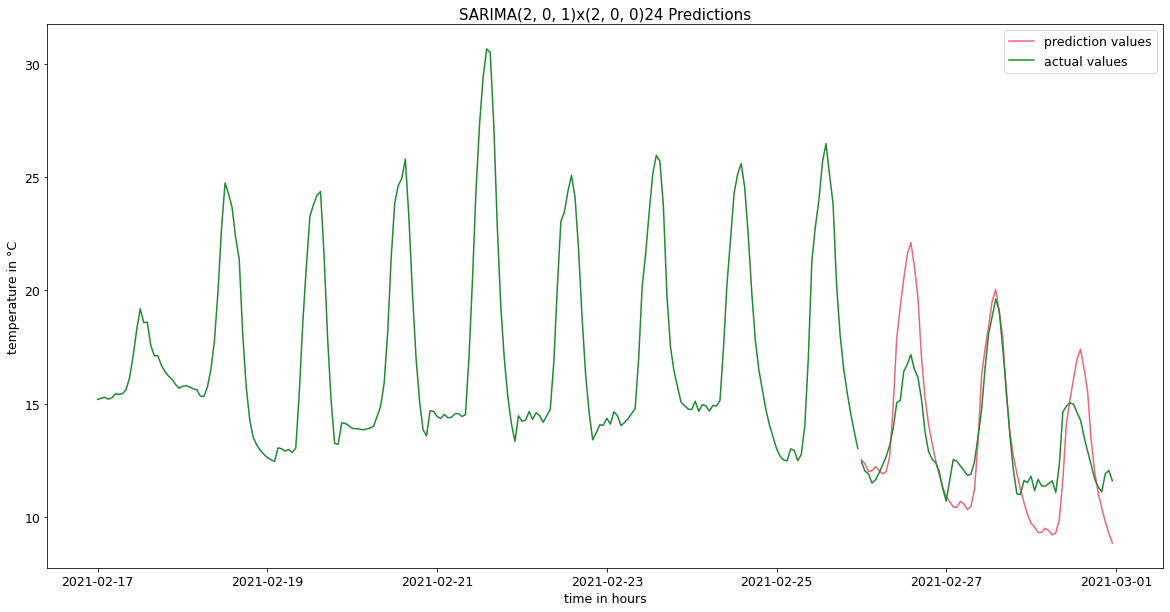

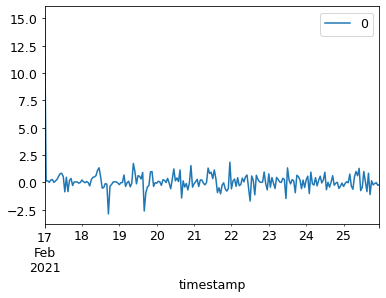

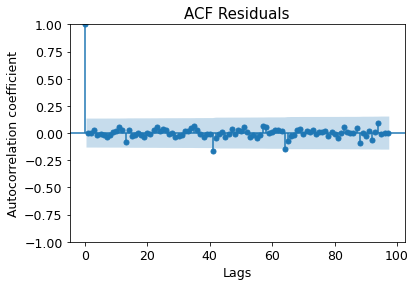

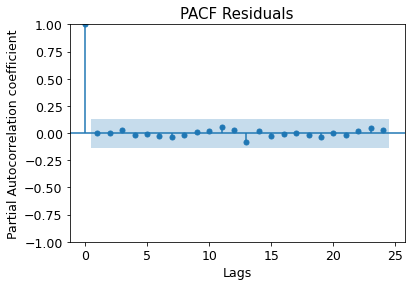

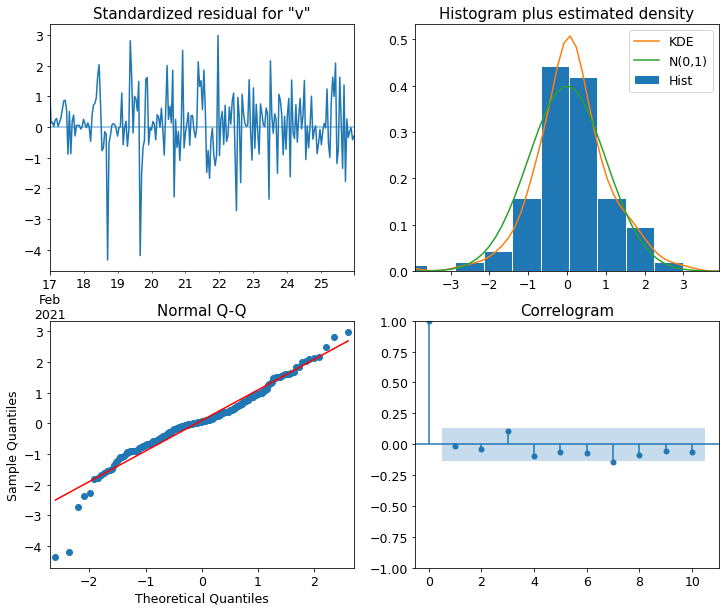

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                  216
Model:             SARIMAX(2, 0, 1)x(2, 0, [], 24)   Log Likelihood                -218.548
Date:                             Mon, 04 Jul 2022   AIC                            449.096
Time:                                     08:44:41   BIC                            469.348
Sample:                                 02-17-2021   HQIC                           457.278
                                      - 02-25-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5053      0.114     13.184      0.000       1.282       1.729
ar.L2         -0.5227      0.113     -4.622      0.000      -0.744      -0.301
ma.L1         -0.0365      0.136     -0.269      0.788      -0.303       0.229
ar.S.L24       0.4737      0.050      9.457      0.000       0.376       0.572
ar.S.L48       0.3537      0.051      6.987      0.000       0.254       0.453
sigma2         0.3859      0.028     13.924      0.000       0.332       0.440
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                95.93
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                            -0.56
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
model = SARIMAX(train_data, order=(2,0,1), seasonal_order=(2,0,[],24))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='SARIMA(2, 0, 1)x(2, 0, 0)24 Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],
#                 ts_ci.iloc[1:, 1], color='k', alpha=.2, label='prediction interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient")

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

## Gridsearch

In [49]:
p = range(0,3)
d = {0}
q = range(0,2)
pdq = list(itertools.product(p,d,q)) # alle Kombis von p,d,q
p2 = range(0,3)
d2 = range(0,1)
q2 = range(0,2)
pdq2 = list(itertools.product(p2,d2,q2))
s = 24 # Zykluslänge
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2] # alle Kombis von p,d,q
combs = {}
aics = []

In [50]:
# Für jede Modellkombination ein SARIMA-Modell anlernen
for combination in pdq:
    for seasonal_combination in pdqs2:
        
        model = SARIMAX(train_data, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=True,
                                             enforce_invertibility=True)
        model = model.fit(disp=False)
        combs.update({model.aic : [combination, seasonal_combination]})
        aics.append(model.aic)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Usin

In [55]:
best_aic = min(aics)
print('best aic: ', round(best_aic, 3))
print(14*'==')
print ('ARIMA parameters: (', combs[best_aic][0][0], ',', combs[best_aic][0][1],',', combs[best_aic][0][2],')')
print('Seasonal parameters:', combs[best_aic][1])

best aic:  446.973
ARIMA parameters: ( 2 , 0 , 0 )
Seasonal parameters: (1, 0, 1, 24)


### SARIMA( 2,0,0)x(1,0,1)24

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Mean absolute error (MAE):  1.632305566181225
Mean squared error (MSE):  4.973057247793988
Root Mean sqaured error (RMSE):  2.230035257074199


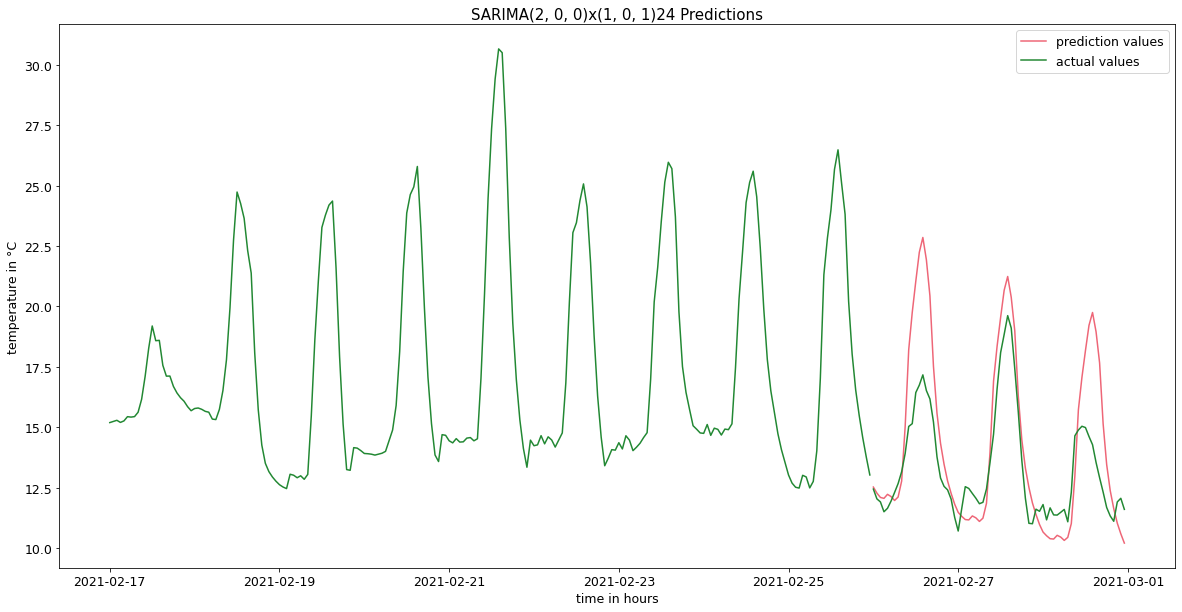

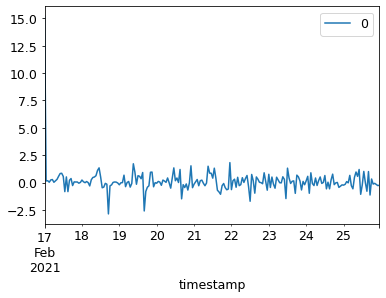

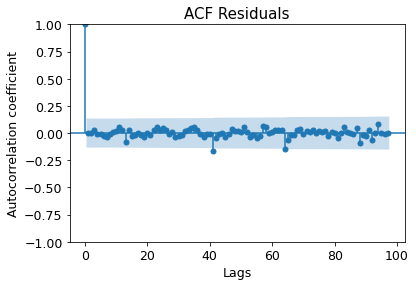

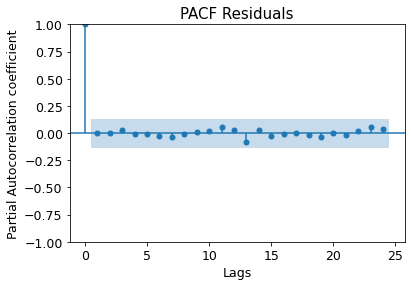

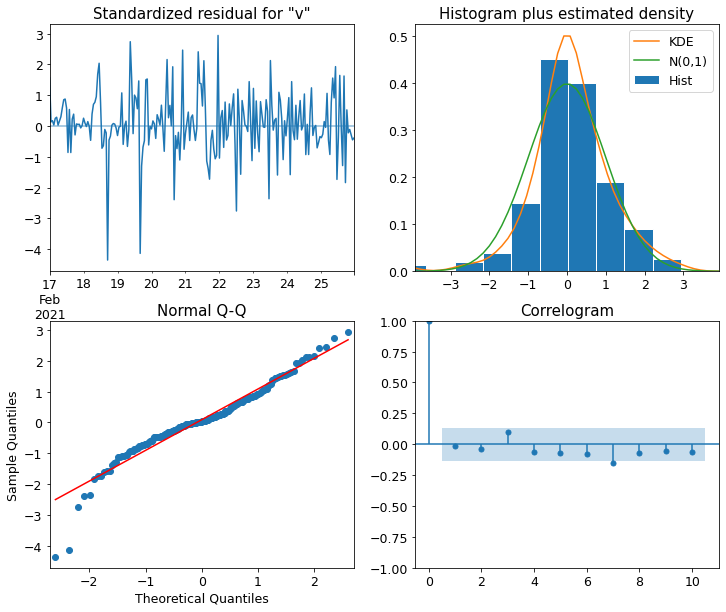

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  216
Model:             SARIMAX(2, 0, 0)x(1, 0, [1], 24)   Log Likelihood                -218.486
Date:                              Mon, 04 Jul 2022   AIC                            446.973
Time:                                      08:44:07   BIC                            463.849
Sample:                                  02-17-2021   HQIC                           453.791
                                       - 02-25-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4809      0.053     27.783      0.000       1.376       1.585
ar.L2         -0.5002      0.053     -9.355      0.000      -0.605      -0.395
ar.S.L24       0.9302      0.028     32.990      0.000       0.875       0.986
ma.S.L24      -0.4788      0.072     -6.634      0.000      -0.620      -0.337
sigma2         0.3839      0.028     13.615      0.000       0.329       0.439
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                93.35
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                            -0.54
Prob(H) (two-sided):                  0.23   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [62]:
model = SARIMAX(train_data, order=(2,0,0), seasonal_order=(1,0,1,24))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='SARIMA(2, 0, 0)x(1, 0, 1)24 Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],
#                 ts_ci.iloc[1:, 1], color='k', alpha=.2, label='prediction interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient") 

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

In [ ]:
connection.close()